In [1]:
import os
from sqlalchemy import create_engine
import pandas as pd

# Fetch credentials from environment variables
db_endpoint = os.getenv("DB_ENDPOINT")
db_username = os.getenv("DB_USERNAME")
db_password = os.getenv("DB_PASSWORD")
db_name = os.getenv("DB_NAME")
db_port = os.getenv("DB_PORT", "5432")  # Default to 5432 if not set

# Create the connection string
engine = create_engine(f"postgresql://{db_username}:{db_password}@{db_endpoint}:{db_port}/{db_name}")

# Load stocks_data and etf_data from the RDS database
stocks_data = pd.read_sql('SELECT * FROM stocks_data', con=engine)
etfs_data = pd.read_sql('SELECT * FROM etf_data', con=engine)

# Group by 'Identifier' and calculate the total volume for each stock and ETF
stocks_volume = stocks_data.groupby('Identifier')['Volume'].sum().reset_index()
etfs_volume = etfs_data.groupby('Identifier')['Volume'].sum().reset_index()

# Sort by volume in descending order and select the top 5 most valuable stocks and ETFs
top_5_stocks = stocks_volume.sort_values(by='Volume', ascending=False).head(5)
top_5_etfs = etfs_volume.sort_values(by='Volume', ascending=False).head(5)

# Display the results
print("Top 5 Most Valuable Stocks by Volume:")
print(top_5_stocks)

print("\nTop 5 Most Valuable ETFs by Volume:")
print(top_5_etfs)

# Optionally, save the results to CSV files

Top 5 Most Valuable Stocks by Volume:
     Identifier        Volume
12         aapl  891950579821
3408       intc  652521196136
4333       msft  634313240042
1548       csco  497714239640
616         bac  431496137336

Top 5 Most Valuable ETFs by Volume:
     Identifier        Volume
1103        spy  537938859883
936         qqq  378636313144
1305        xlf  289907767738
251         eem  189023759537
677         iwm  176930155873


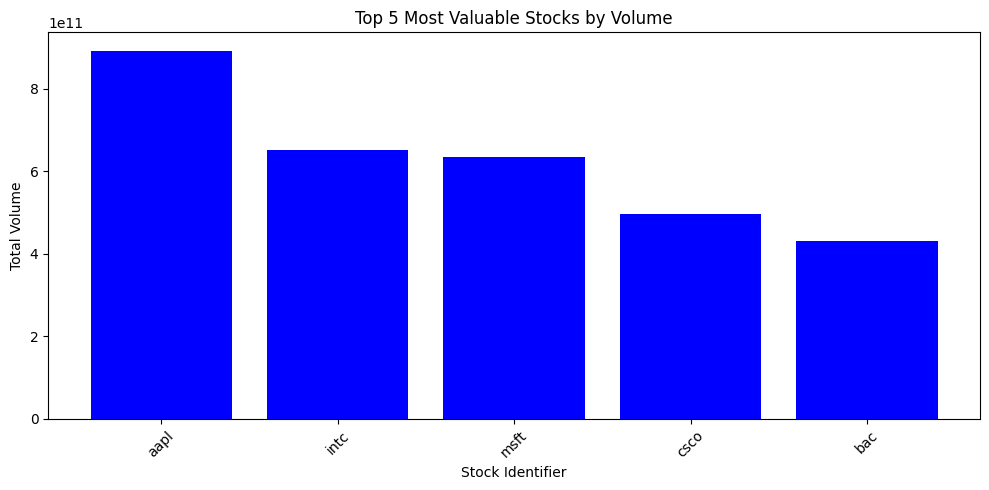

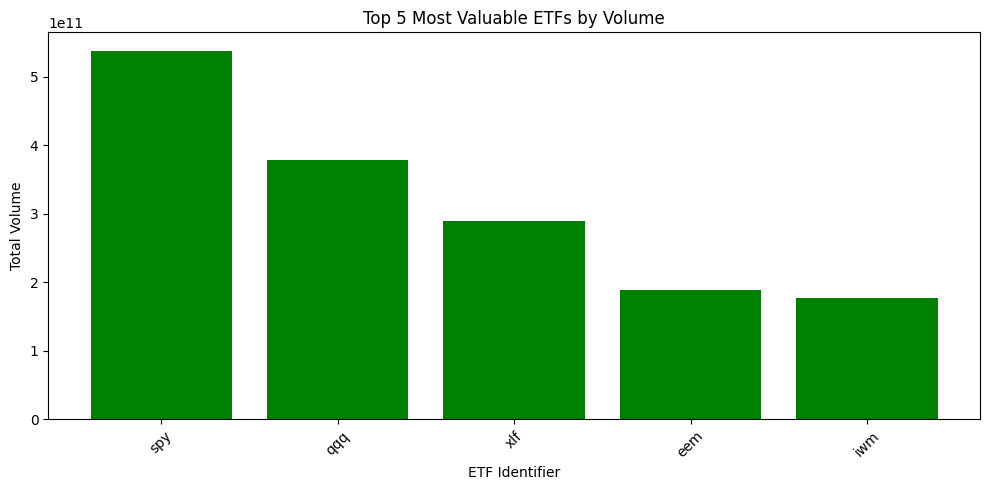

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the top 5 stocks by volume
plt.figure(figsize=(10, 5))
plt.bar(top_5_stocks['Identifier'], top_5_stocks['Volume'], color='blue')
plt.xlabel('Stock Identifier')
plt.ylabel('Total Volume')
plt.title('Top 5 Most Valuable Stocks by Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the top 5 ETFs by volume
plt.figure(figsize=(10, 5))
plt.bar(top_5_etfs['Identifier'], top_5_etfs['Volume'], color='green')
plt.xlabel('ETF Identifier')
plt.ylabel('Total Volume')
plt.title('Top 5 Most Valuable ETFs by Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [3]:
#Create dataframes for each of the top 5 stocks
top_5_stock_dfs = {}
for identifier in top_5_stocks['Identifier']:
    top_5_stock_dfs[f"{identifier}_df"] = stocks_data[stocks_data['Identifier'] == identifier]

# Create dataframes for each of the top 5 ETFs
top_5_etf_dfs = {}
for identifier in top_5_etfs['Identifier']:
    top_5_etf_dfs[f"{identifier}_df"] = etfs_data[etfs_data['Identifier'] == identifier]


In [4]:
def view_dataframe_info(df, identifier):
    """
    This function takes a DataFrame and prints information about it.

    Parameters:
    df (pd.DataFrame): The DataFrame to be viewed.
    identifier (str): Identifier of the stock or ETF for better labeling.

    Returns:
    None: Prints the head and info of the DataFrame.
    """
    if df is not None and not df.empty:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        print(f"Displaying information for {identifier}:\n")
        print(df.head())  # Display the first few rows
        print("\nDataFrame Info:")
        print(df.info())  # Display general information about the DataFrame
    else:
        print(f"No data found for identifier '{identifier}' or DataFrame is empty.")

# Example usage with AAPL DataFrame
aapl_df = top_5_stock_dfs.get('aapl_df')
view_dataframe_info(aapl_df, 'AAPL')


Displaying information for AAPL:

               Open     High      Low    Close    Volume  OpenInt Identifier
Date                                                                        
1984-09-07  0.42388  0.42902  0.41874  0.42388  23220030        0       aapl
1984-09-10  0.42388  0.42516  0.41366  0.42134  18022532        0       aapl
1984-09-11  0.42516  0.43668  0.42516  0.42902  42498199        0       aapl
1984-09-12  0.42902  0.43157  0.41618  0.41618  37125801        0       aapl
1984-09-13  0.43927  0.44052  0.43927  0.43927  57822062        0       aapl

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8364 entries, 1984-09-07 to 2017-11-10
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        8364 non-null   float64
 1   High        8364 non-null   float64
 2   Low         8364 non-null   float64
 3   Close       8364 non-null   float64
 4   Volume      8364 non-null   int64  

<ipython-input-4-66f5403923f1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


In [5]:
!pip install pmdarima
import numpy as np # linear algebra
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import math
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_error

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.8 MB/s eta 0:00:00


In [6]:
import plotly.graph_objects as go
import plotly.io as pio

def plot_open_close(df, identifier):
    """
    This function takes a DataFrame and its identifier and plots the Open and Close prices using Plotly.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data to be plotted.
    identifier (str): The identifier of the stock or ETF to use in the plot title.

    Returns:
    None: Displays an interactive plot of Open and Close prices.
    """
    if df is not None and not df.empty:
        # Create traces for Open and Close prices
        trace_open = go.Scatter(x=df.index, y=df['Open'], mode='lines', name=f'Open Price - {identifier}')
        trace_close = go.Scatter(x=df.index, y=df['Close'], mode='lines', name=f'Close Price - {identifier}')

        # Layout settings
        layout = go.Layout(
            title=f'Opening & Closing Price of {identifier}',
            xaxis_title='Date',
            yaxis_title='Price (USD)',
            legend=dict(x=0, y=1.0),
            margin=dict(l=80, r=80, t=40, b=40),
            height=500,
            width=1100,
        )

        # Combine the traces and layout
        fig = go.Figure(data=[trace_open, trace_close], layout=layout)

        # Display the plot
        pio.show(fig)
    else:
        print(f"No data found for identifier '{identifier}' or DataFrame is empty.")

# Example usage with AAPL DataFrame
# aapl_df = top_5_stock_dfs.get('aapl_df')
# plot_open_close(aapl_df, 'AAPL')


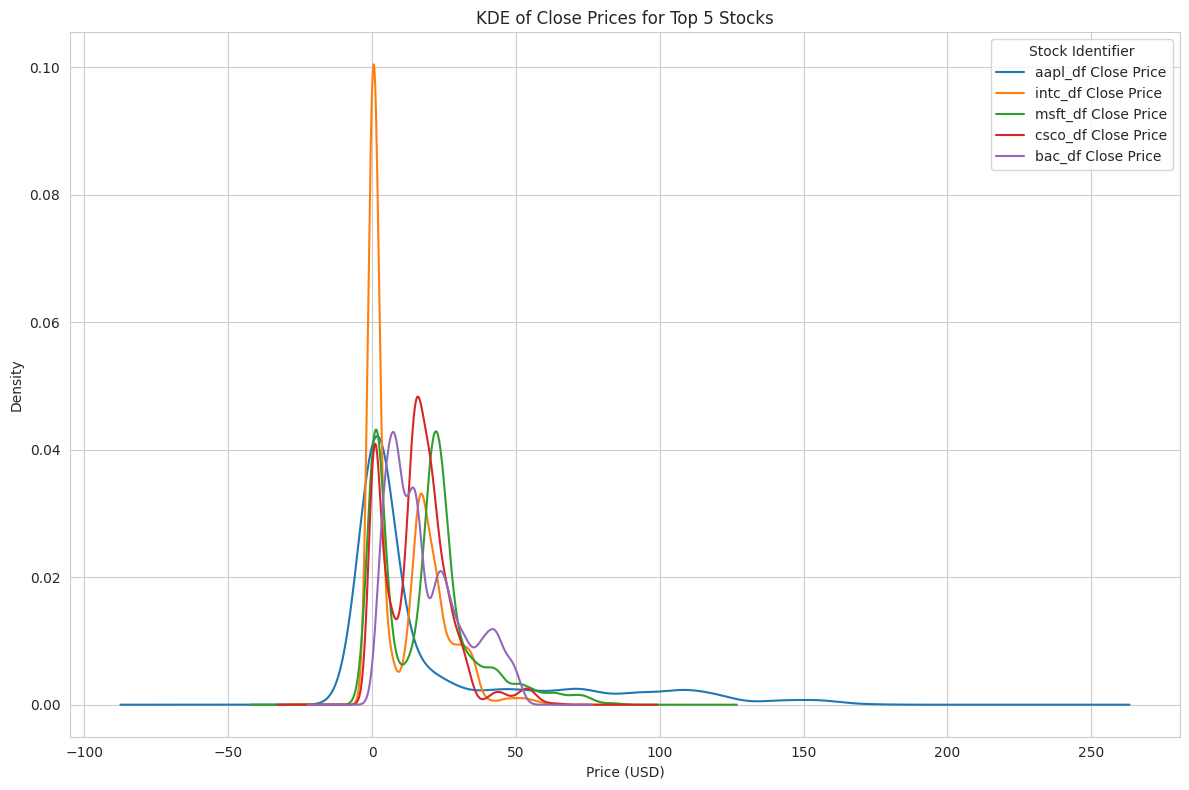

In [7]:
import matplotlib.pyplot as plt

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each stock DataFrame in the dictionary and plot the KDE of the "Close" price
for identifier, df in top_5_stock_dfs.items():
    df["Close"].plot(kind='kde', label=f'{identifier} Close Price')

# Adding details to the plot
plt.title('KDE of Close Prices for Top 5 Stocks')
plt.xlabel('Price (USD)')
plt.ylabel('Density')
plt.grid(True)
plt.legend(title="Stock Identifier")
plt.tight_layout()

# Display the combined plot
plt.show()


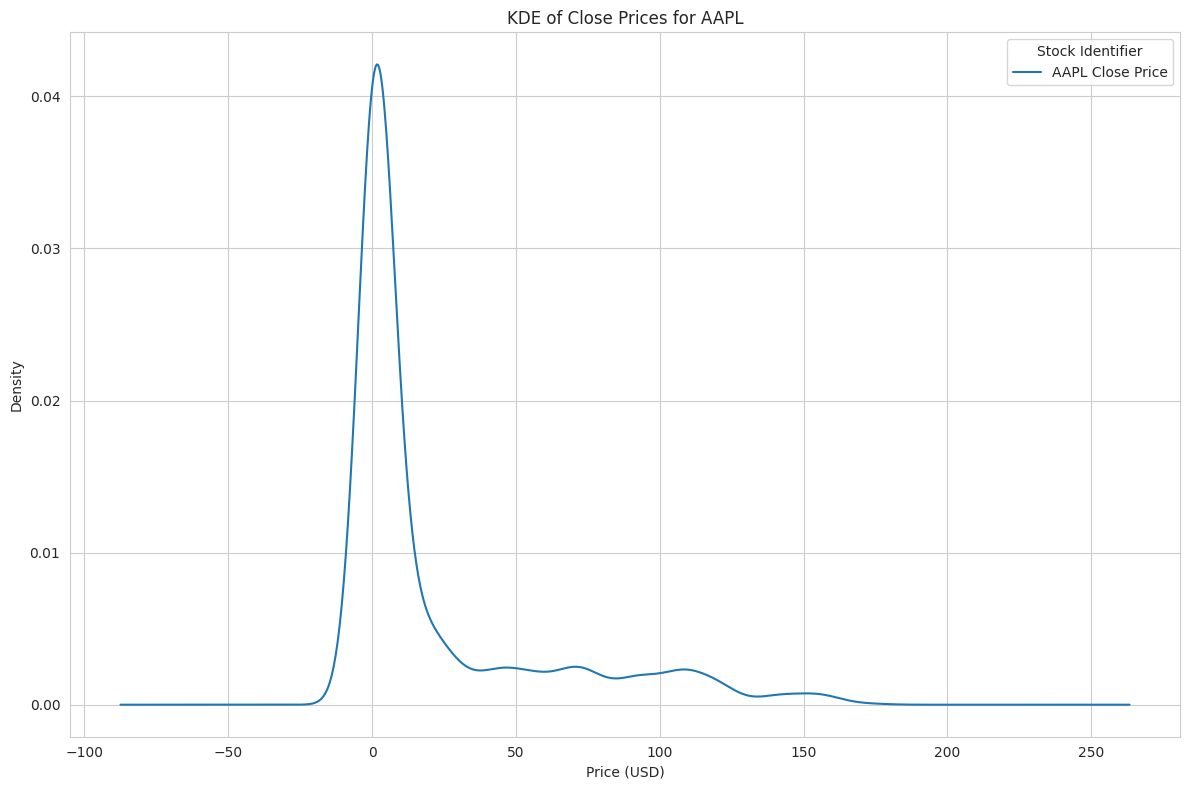

In [8]:
import matplotlib.pyplot as plt

def plot_kde(df, identifier):
    """
    This function takes a DataFrame and its identifier and plots the KDE of the 'Close' prices.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data to be plotted.
    identifier (str): The identifier of the stock or ETF to use in the plot label.

    Returns:
    None: Displays the KDE plot of Close prices.
    """
    if df is not None and not df.empty:
        # Initialize the plot
        plt.figure(figsize=(12, 8))

        # Plot the KDE of the 'Close' price for the given DataFrame
        df["Close"].plot(kind='kde', label=f'{identifier} Close Price')

        # Adding details to the plot
        plt.title(f'KDE of Close Prices for {identifier}')
        plt.xlabel('Price (USD)')
        plt.ylabel('Density')
        plt.grid(True)
        plt.legend(title="Stock Identifier")
        plt.tight_layout()

        # Display the plot
        plt.show()
    else:
        print(f"No data found for identifier '{identifier}' or DataFrame is empty.")

# Example usage with AAPL DataFrame
aapl_df = top_5_stock_dfs.get('aapl_df')
plot_kde(aapl_df, 'AAPL')

In [9]:
def test_stationarity(timeseries, identifier):
    """
    This function takes a time series data as input and performs the following:
    1. Computes rolling statistics (mean and standard deviation) over a window of 12 months.
    2. Plots the original time series along with its rolling mean and standard deviation using Plotly.
    3. Conducts the Augmented Dickey-Fuller (ADF) test to statistically check for stationarity.

    Parameters:
    timeseries (pd.Series): Time series data to be analyzed.
    identifier (str): Identifier for the stock or ETF to use in the plot title.

    Returns:
    None: Outputs plots and test results.
    """
    # Step 1: Calculate rolling mean and standard deviation with a window size of 12
    rolling_mean = timeseries.rolling(window=12).mean()  # Calculate 12-month rolling mean
    rolling_std = timeseries.rolling(window=12).std()    # Calculate 12-month rolling standard deviation

    # Step 2: Plot original time series and its rolling statistics using Plotly
    fig = go.Figure()

    # Adding the original time series to the plot
    fig.add_trace(go.Scatter(x=timeseries.index, y=timeseries, mode='lines', name='Original', line=dict(color='blue')))

    # Adding the rolling mean to the plot
    fig.add_trace(go.Scatter(x=rolling_mean.index, y=rolling_mean, mode='lines', name='Rolling Mean', line=dict(color='red')))

    # Adding the rolling standard deviation to the plot
    fig.add_trace(go.Scatter(x=rolling_std.index, y=rolling_std, mode='lines', name='Rolling Std Dev', line=dict(color='black')))

    # Update the layout of the plot
    fig.update_layout(title=f'Rolling Mean and Standard Deviation for {identifier}',
                      xaxis_title='Date',
                      yaxis_title='Value',
                      legend=dict(x=0, y=1),
                      height=600,
                      width=1200)

    # Show the plot
    fig.show()

    # Step 3: Perform the Augmented Dickey-Fuller test to statistically check for stationarity
    print(f"Results of Augmented Dickey-Fuller Test for {identifier}:")
    adf_test = adfuller(timeseries.dropna(), autolag='AIC')  # Drop NA values and perform ADF test with AIC criterion

    # Display ADF test results
    results = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', 'No. of Lags Used', 'Number of Observations Used'])
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    print(results)

In [10]:
print("\nTesting Stationarity for Top 5 Stocks:\n")
for identifier, df in top_5_stock_dfs.items():
    test_stationarity(df['Close'], identifier)

# test_stationarity(aapl_df['Close'], 'AAPL')


Testing Stationarity for Top 5 Stocks:



Results of Augmented Dickey-Fuller Test for aapl_df:
Test Statistic                    4.373924
p-value                           1.000000
No. of Lags Used                 37.000000
Number of Observations Used    8326.000000
Critical Value (1%)              -3.431136
Critical Value (5%)              -2.861887
Critical Value (10%)             -2.566955
dtype: float64


Results of Augmented Dickey-Fuller Test for intc_df:
Test Statistic                    -0.650997
p-value                            0.859038
No. of Lags Used                  39.000000
Number of Observations Used    11516.000000
Critical Value (1%)               -3.430918
Critical Value (5%)               -2.861791
Critical Value (10%)              -2.566904
dtype: float64


Results of Augmented Dickey-Fuller Test for msft_df:
Test Statistic                    2.667362
p-value                           0.999085
No. of Lags Used                 36.000000
Number of Observations Used    7946.000000
Critical Value (1%)              -3.431173
Critical Value (5%)              -2.861904
Critical Value (10%)             -2.566964
dtype: float64


Results of Augmented Dickey-Fuller Test for csco_df:
Test Statistic                   -1.859049
p-value                           0.351564
No. of Lags Used                 35.000000
Number of Observations Used    6928.000000
Critical Value (1%)              -3.431294
Critical Value (5%)              -2.861957
Critical Value (10%)             -2.566992
dtype: float64


Results of Augmented Dickey-Fuller Test for bac_df:
Test Statistic                   -1.520850
p-value                           0.523173
No. of Lags Used                 36.000000
Number of Observations Used    7892.000000
Critical Value (1%)              -3.431179
Critical Value (5%)              -2.861906
Critical Value (10%)             -2.566965
dtype: float64


In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Function to perform seasonal decomposition on a selected DataFrame
def decompose_time_series(identifier, stock=True):
    """
    This function takes an identifier and performs seasonal decomposition on the Close prices.
    It plots the original series, trend, seasonality, and residual components.

    Parameters:
    identifier (str): The identifier of the stock or ETF.
    stock (bool): Set to True for stock, False for ETF.

    Returns:
    None: Displays the plots.
    """
    # Select the appropriate DataFrame
    if stock:
        df = top_5_stock_dfs.get(f"{identifier}_df")
    else:
        df = top_5_etf_dfs.get(f"{identifier}_df")

    # Ensure df exists and is not empty
    if df is not None and not df.empty:
        # Convert 'Date' to datetime and set it as the index, if not already done
        # df['Date'] = pd.to_datetime(df['Date'])
        # df.set_index('Date', inplace=True)

        # Perform seasonal decomposition using multiplicative model
        result = seasonal_decompose(df["Close"], model='multiplicative', period=30)

        # Create subplots
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 12))

        # Plot Original Series
        ax1.plot(df["Close"], label='Original', color='blue')
        ax1.set_title('Original Series')
        ax1.legend(loc='best')

        # Plot Trend Component
        ax2.plot(result.trend, label='Trend', color='orange')
        ax2.set_title('Trend Component')
        ax2.legend(loc='best')

        # Plot Seasonal Component
        ax3.plot(result.seasonal, label='Seasonality', color='green')
        ax3.set_title('Seasonal Component')
        ax3.legend(loc='best')

        # Plot Residual Component
        ax4.plot(result.resid, label='Residuals', color='red')
        ax4.set_title('Residual Component')
        ax4.legend(loc='best')

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()

    else:
        print(f"No data found for identifier '{identifier}' or DataFrame is empty.")



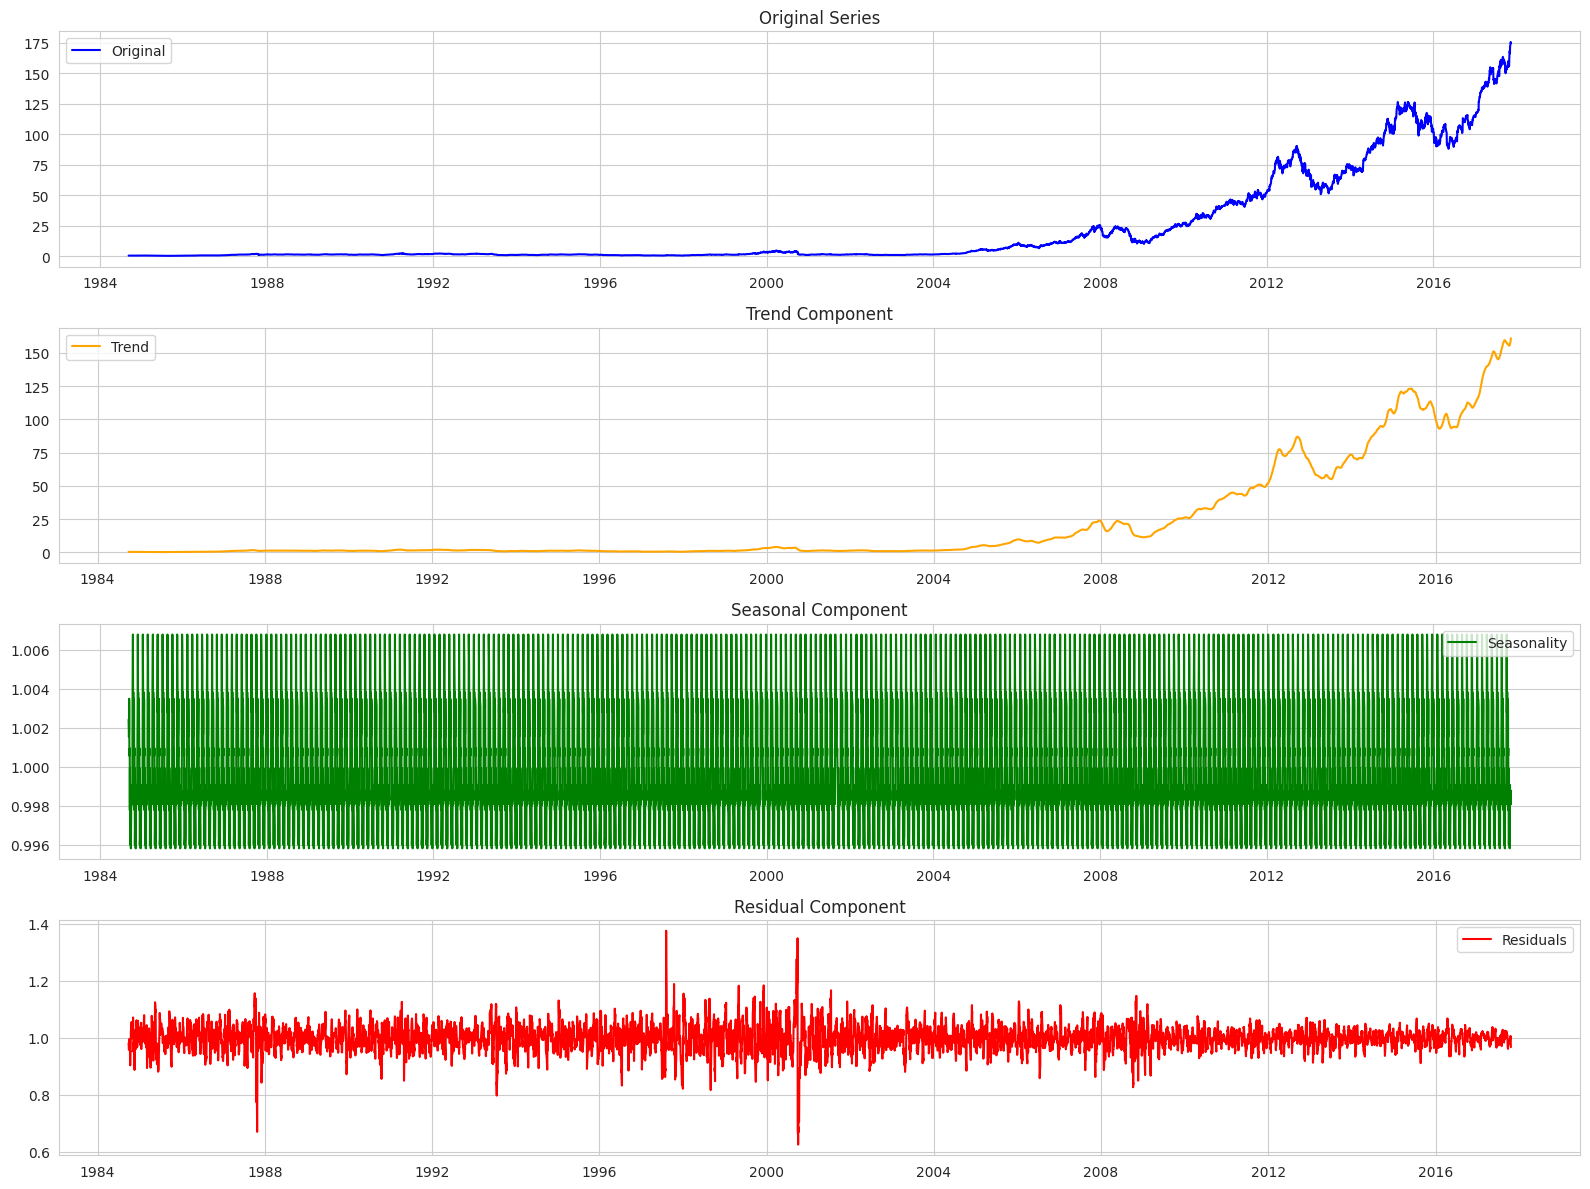

In [22]:
decompose_time_series('aapl', stock=True)

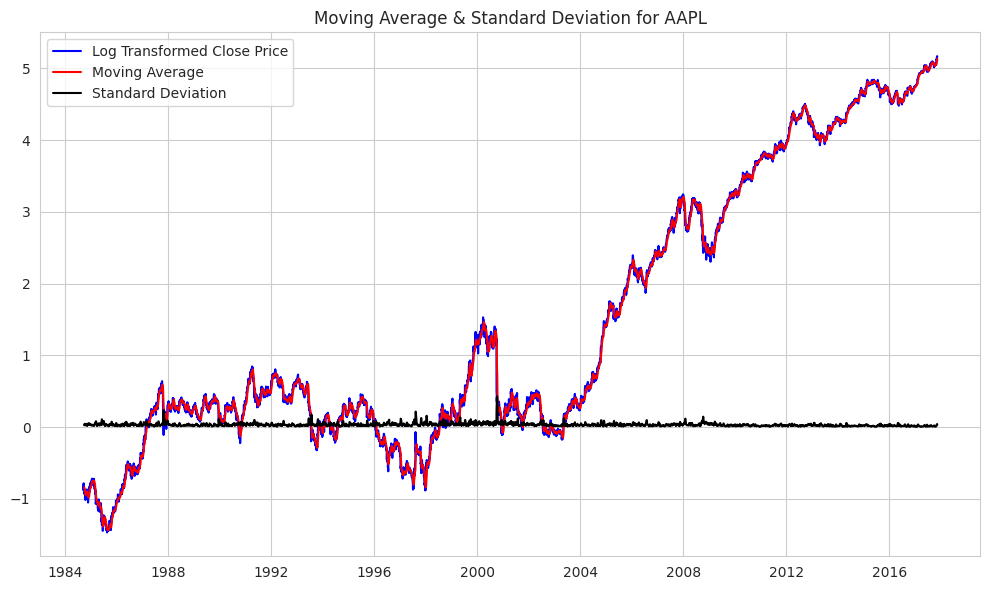

In [24]:
from pylab import rcParams

def plot_log_moving_avg_std(df, identifier):
    """
    This function takes a DataFrame and an identifier to plot the log-transformed "Close" price
    with moving average and standard deviation.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data to be analyzed.
    identifier (str): The identifier of the stock or ETF to use in the plot title.

    Returns:
    None: Displays the plot.
    """
    if df is not None and not df.empty:
        # Set figure size
        rcParams['figure.figsize'] = 10, 6

        # Log transform of the "Close" price
        df_log = np.log(df["Close"])

        # Calculate rolling mean and standard deviation with a window of 12
        moving_avg = df_log.rolling(12).mean()
        std_dev = df_log.rolling(12).std()

        # Plot the moving average and standard deviation
        plt.plot(df_log, color="blue", label="Log Transformed Close Price")
        plt.plot(moving_avg, color="red", label="Moving Average")
        plt.plot(std_dev, color="black", label="Standard Deviation")

        # Adding title and legend
        plt.title(f'Moving Average & Standard Deviation for {identifier}')
        plt.legend(loc='best')

        # Display the plot
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data found for identifier '{identifier}' or DataFrame is empty.")

# Example usage with AAPL DataFrame
aapl_df = top_5_stock_dfs.get('aapl_df')
plot_log_moving_avg_std(aapl_df, 'AAPL')


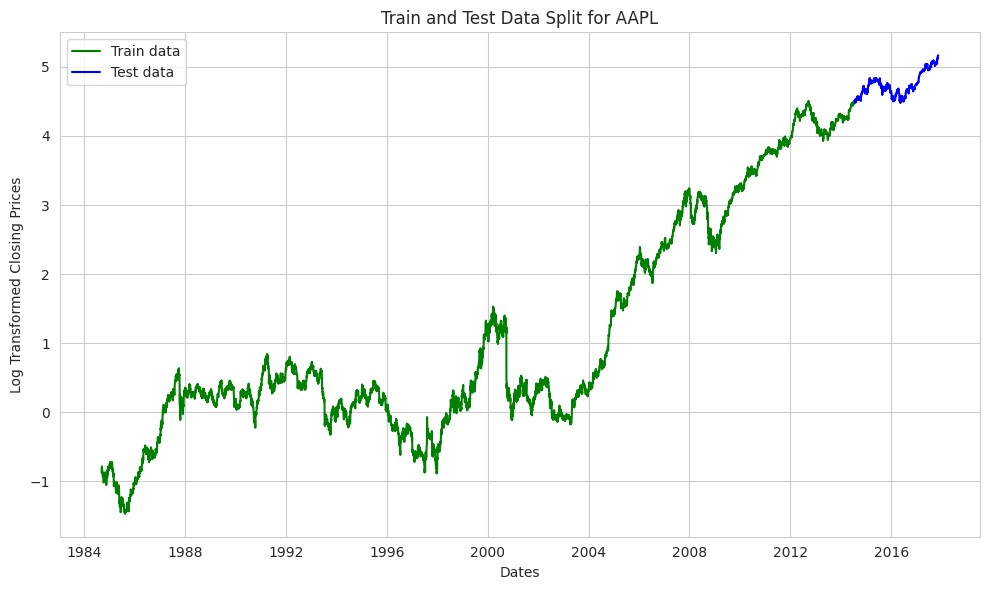

In [25]:
def plot_train_test_split(df, identifier):
    """
    This function takes a DataFrame and an identifier to split the log-transformed "Close" price
    into train and test sets, and plots them.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data to be analyzed.
    identifier (str): The identifier of the stock or ETF to use in the plot title.

    Returns:
    None: Displays the plot of train and test data.
    """
    if df is not None and not df.empty:
        # Log transform of the "Close" price
        df_log = np.log(df["Close"])

        # Split data into train and test sets (90% train and 10% test)
        train_data = df_log[3:int(len(df_log) * 0.9)]
        test_data = df_log[int(len(df_log) * 0.9):]

        # Plot train and test data
        plt.figure(figsize=(10, 6))
        plt.grid(True)
        plt.xlabel('Dates')
        plt.ylabel('Log Transformed Closing Prices')
        plt.plot(train_data, 'green', label='Train data')
        plt.plot(test_data, 'blue', label='Test data')
        plt.title(f'Train and Test Data Split for {identifier}')
        plt.legend()

        # Display the plot
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data found for identifier '{identifier}' or DataFrame is empty.")

# # Example usage with AAPL DataFrame
aapl_df = top_5_stock_dfs.get('aapl_df')
plot_train_test_split(aapl_df, 'AAPL')


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31377.404, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31375.594, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-31375.597, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31375.178, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-31373.598, Time=0.92 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.915 seconds
ARIMA Model Summary for AAPL:

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7524
Model:               SARIMAX(0, 1, 0)   Log Likelihood               15690.702
Date:                Mon, 28 Oct 2024   AIC                         -31377.404
Time:                        01:25:13   BIC                         -31363.553
Sample:                             0   HQIC                        -31372.648
                               - 75

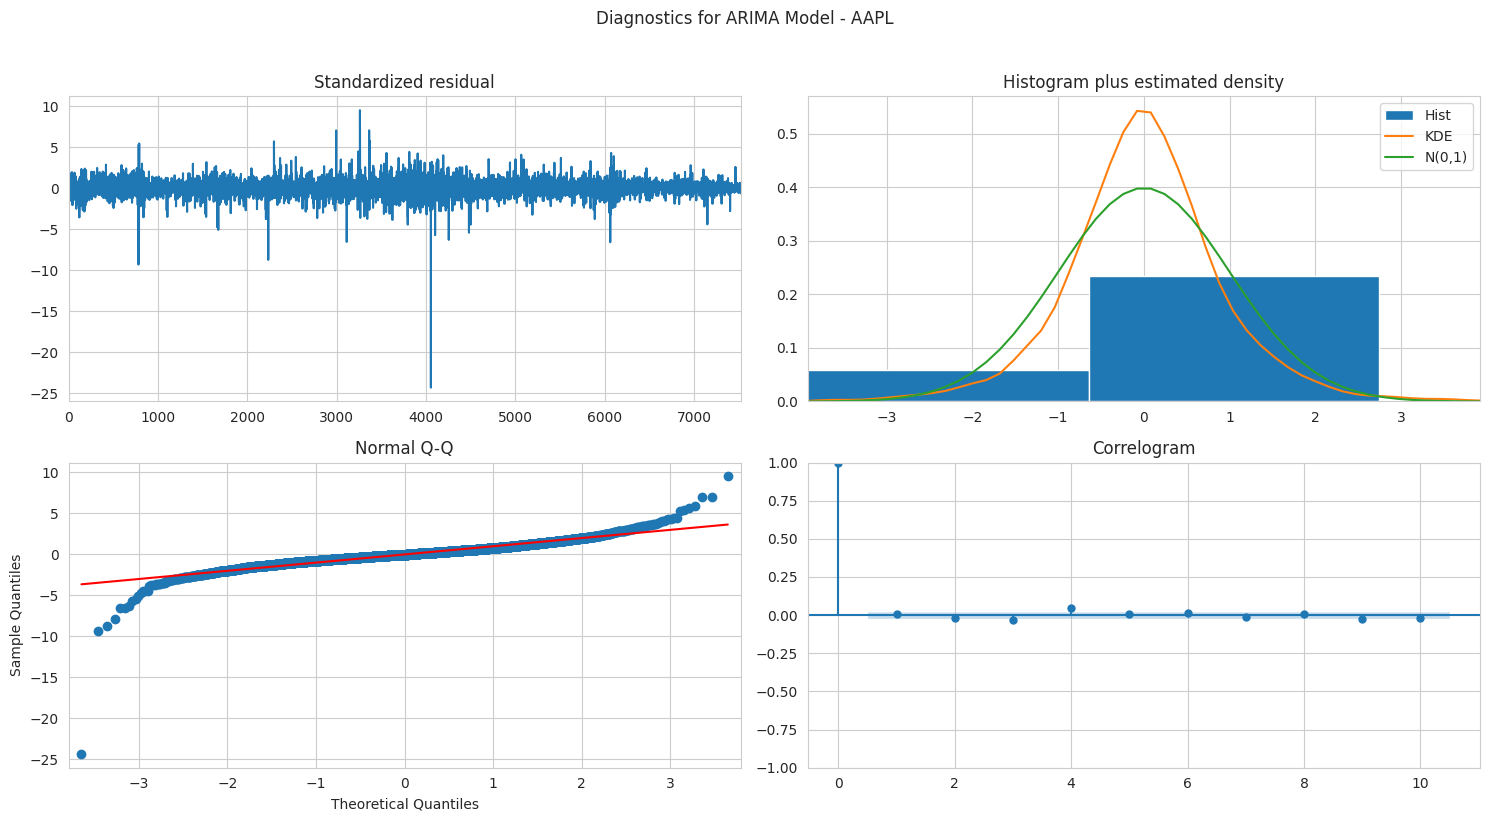

In [26]:
from pmdarima import auto_arima

def fit_auto_arima(train_data, identifier):
    """
    This function takes a time series data for training and an identifier to fit an ARIMA model automatically.
    It prints a summary of the model and plots diagnostic information.

    Parameters:
    train_data (pd.Series): The time series data used for training.
    identifier (str): The identifier of the stock or ETF to use in the model summary and plot title.

    Returns:
    model_autoARIMA: The fitted ARIMA model.
    """
    if train_data is not None and not train_data.empty:
        # Fit an ARIMA model automatically using pmdarima's auto_arima
        model_autoARIMA = auto_arima(
            train_data,            # The time series data for training
            start_p=0,             # Starting value for the parameter p (AR part of ARIMA)
            start_q=0,             # Starting value for the parameter q (MA part of ARIMA)
            test='adf',            # Use the Augmented Dickey-Fuller test to find the optimal 'd'
            max_p=3,               # Maximum value for the parameter p to search
            max_q=3,               # Maximum value for the parameter q to search
            m=1,                   # Frequency of the series (1 for non-seasonal data)
            d=None,                # Let the model determine the optimal value for 'd'
            seasonal=False,        # No seasonal component (set to True if you have seasonality)
            start_P=0,             # Starting value for the parameter P (Seasonal AR part, if seasonal=True)
            D=0,                   # Seasonal differencing order, 0 means no seasonal differencing
            trace=True,            # Print progress of the fitting process
            error_action='ignore', # Ignore errors during fitting (useful for large parameter searches)
            suppress_warnings=True, # Suppress warnings to keep output clean
            stepwise=True          # Use stepwise algorithm for faster model selection
        )

        # Print a summary of the selected ARIMA model
        print(f"ARIMA Model Summary for {identifier}:\n")
        print(model_autoARIMA.summary())

        # Plot diagnostics of the fitted ARIMA model
        model_autoARIMA.plot_diagnostics(figsize=(15, 8))
        plt.suptitle(f'Diagnostics for ARIMA Model - {identifier}', y=1.02)  # Add a title to the figure
        plt.tight_layout()
        plt.show()

        # Return the fitted model for further use
        return model_autoARIMA
    else:
        print(f"No data found for identifier '{identifier}' or train data is empty.")
        return None

# Example usage with AAPL DataFrame
aapl_df = top_5_stock_dfs.get('aapl_df')
if aapl_df is not None:
    # Use the training data split previously
    df_log = np.log(aapl_df["Close"])
    train_data = df_log[3:int(len(df_log) * 0.9)]
    fit_auto_arima(train_data, 'AAPL')


In [27]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

def fit_arima_model(train_data, identifier, order=(1, 1, 2)):
    """
    This function takes time series data for training, an identifier, and fits an ARIMA model.
    It prints a summary of the model.

    Parameters:
    train_data (pd.Series): The time series data used for training.
    identifier (str): The identifier of the stock or ETF to use in the model summary.
    order (tuple): The (p, d, q) order for the ARIMA model. Default is (1, 1, 2).

    Returns:
    fitted: The fitted ARIMA model.
    """
    if train_data is not None and not train_data.empty:
        # Ensure the data has a datetime index and set the frequency
        train_data.index = pd.to_datetime(train_data.index)
        train_data = train_data.asfreq(train_data.index.inferred_freq)

        # Define and fit the ARIMA model
        model = ARIMA(train_data, order=order)
        fitted = model.fit()

        # Print the summary of the model
        print(f"ARIMA Model Summary for {identifier}:\n")
        print(fitted.summary())

        # Return the fitted model for further use
        return fitted
    else:
        print(f"No data found for identifier '{identifier}' or train data is empty.")
        return None

# # Example usage with AAPL DataFrame
aapl_df = top_5_stock_dfs.get('aapl_df')
if aapl_df is not None:
    # Use the training data split previously
    df_log = np.log(aapl_df["Close"])
    train_data = df_log[3:int(len(df_log) * 0.9)]
    fit_arima_model(train_data, 'AAPL')

ARIMA Model Summary for AAPL:

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                10902
Model:                 ARIMA(1, 1, 2)   Log Likelihood               15419.472
Date:                Mon, 28 Oct 2024   AIC                         -30830.944
Time:                        01:25:21   BIC                         -30801.758
Sample:                    09-12-1984   HQIC                        -30821.107
                         - 07-18-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3487      0.145     -2.409      0.016      -0.632      -0.065
ma.L1          0.2512      0.144      1.746      0.081      -0.031       0.533
ma.L2         -0.0985

In [28]:
def forecast_arima(fitted_model, steps, identifier):
    """
    This function takes a fitted ARIMA model, forecasts the next steps, and prints the forecast results.

    Parameters:
    fitted_model: The fitted ARIMA model.
    steps (int): Number of steps to forecast into the future.
    identifier (str): The identifier of the stock or ETF for labeling the forecast output.

    Returns:
    tuple: Returns the forecast mean, standard errors, and confidence intervals.
    """
    if fitted_model is not None:
        # Forecast for the specified number of steps
        forecast_result = fitted_model.get_forecast(steps=steps)

        # Extract the forecast mean, standard error, and confidence intervals
        fc = forecast_result.predicted_mean
        se = forecast_result.se_mean
        conf = forecast_result.conf_int(alpha=0.05)

        # Print forecast results
        print(f"\nForecast Results for {identifier}:\n")
        print("Forecasted Values:\n", fc)
        print("\nStandard Errors:\n", se)
        print("\nConfidence Intervals:\n", conf)

        # Return the forecasted values, standard errors, and confidence intervals
        return fc, se, conf
    else:
        print(f"No valid fitted model found for identifier '{identifier}'.")
        return None, None, None

# # Example usage with the AAPL ARIMA model
aapl_df = top_5_stock_dfs.get('aapl_df')
if aapl_df is not None:
    # Log transform of the "Close" price and split data
    df_log = np.log(aapl_df["Close"])
    train_data = df_log[3:int(len(df_log) * 0.9)]

    # Fit the ARIMA model
    fitted_model = fit_arima_model(train_data, 'AAPL')

    # Forecast using the fitted model for the next 321 steps
    if fitted_model is not None:
        forecast_arima(fitted_model, steps=321, identifier='AAPL')


ARIMA Model Summary for AAPL:

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                10902
Model:                 ARIMA(1, 1, 2)   Log Likelihood               15419.472
Date:                Mon, 28 Oct 2024   AIC                         -30830.944
Time:                        01:25:29   BIC                         -30801.758
Sample:                    09-12-1984   HQIC                        -30821.107
                         - 07-18-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3487      0.145     -2.409      0.016      -0.632      -0.065
ma.L1          0.2512      0.144      1.746      0.081      -0.031       0.533
ma.L2         -0.0985

ARIMA Model Summary for AAPL:

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                10902
Model:                 ARIMA(1, 1, 2)   Log Likelihood               15419.472
Date:                Mon, 28 Oct 2024   AIC                         -30830.944
Time:                        01:25:37   BIC                         -30801.758
Sample:                    09-12-1984   HQIC                        -30821.107
                         - 07-18-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3487      0.145     -2.409      0.016      -0.632      -0.065
ma.L1          0.2512      0.144      1.746      0.081      -0.031       0.533
ma.L2         -0.0985

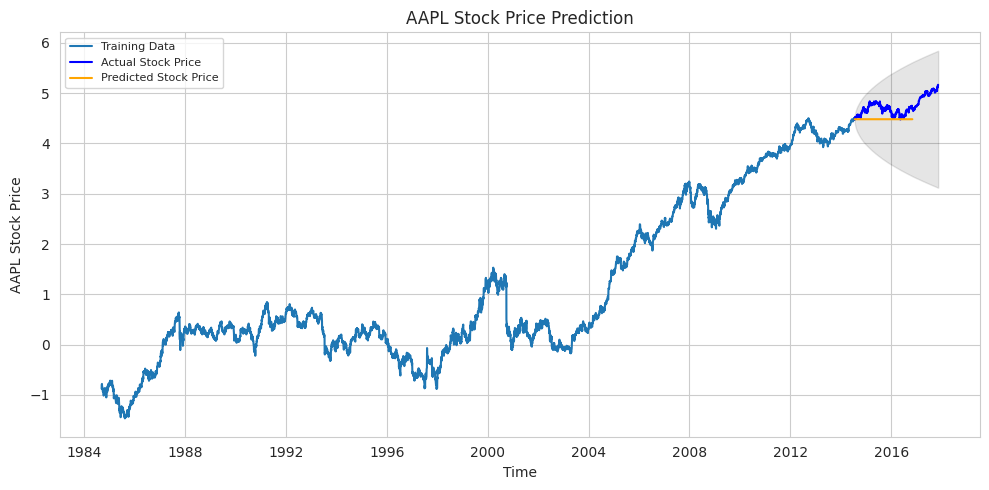

In [29]:
def plot_forecast(train_data, test_data, fc, conf, identifier):
    """
    This function takes training data, test data, forecast results, confidence intervals,
    and an identifier, and plots the predicted values along with the actual values.

    Parameters:
    train_data (pd.Series): The time series training data.
    test_data (pd.Series): The time series test data.
    fc (pd.Series or list): Forecasted values.
    conf (pd.DataFrame or list): Confidence intervals of the forecast.
    identifier (str): The identifier of the stock or ETF for labeling the plot.

    Returns:
    None: Displays the plot with training data, test data, predicted values, and confidence intervals.
    """
    if train_data is not None and not train_data.empty and test_data is not None and not test_data.empty:
        # Ensure the data has valid datetime indices
        train_data.index = pd.to_datetime(train_data.index)
        test_data.index = pd.to_datetime(test_data.index)

        # Convert forecast results to pandas Series with test data index
        fc_series = pd.Series(fc, index=test_data.index)

        # Convert confidence intervals to DataFrame if not already
        if not isinstance(conf, pd.DataFrame):
            conf = pd.DataFrame(conf)

        # Convert confidence intervals to Series for plotting
        lower_series = pd.Series(conf.iloc[:, 0].values, index=test_data.index)
        upper_series = pd.Series(conf.iloc[:, 1].values, index=test_data.index)

        # Plotting the results
        plt.figure(figsize=(10, 5), dpi=100)
        plt.plot(train_data, label='Training Data')
        plt.plot(test_data, color='blue', label='Actual Stock Price')
        plt.plot(fc_series, color='orange', label='Predicted Stock Price')
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)

        # Add title and labels
        plt.title(f'{identifier} Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel(f'{identifier} Stock Price')
        plt.legend(loc='upper left', fontsize=8)

        # Show the plot
        plt.tight_layout()
        plt.show()
    else:
        print(f"One or both of the provided datasets for '{identifier}' are empty or None.")

# # Example usage with AAPL DataFrame
aapl_df = top_5_stock_dfs.get('aapl_df')
if aapl_df is not None:
    # Log transform of the "Close" price and split data
    df_log = np.log(aapl_df["Close"])
    train_data = df_log[3:int(len(df_log) * 0.9)]
    test_data = df_log[int(len(df_log) * 0.9):]

    # Fit the ARIMA model
    fitted_model = fit_arima_model(train_data, 'AAPL')

    # Forecast using the fitted model
    if fitted_model is not None:
        fc, se, conf = forecast_arima(fitted_model, steps=len(test_data), identifier='AAPL')

        # Plot the forecast against actual test data
        if fc is not None and conf is not None:
            plot_forecast(train_data, test_data, fc, conf, 'AAPL')


In [30]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.09749612983079653
MAE: 0.2631568127040624
RMSE: 0.3122437026279258
MAPE: 0.03773342473719684


In [31]:
def report_forecast_performance(test_data, fc, identifier):
    """
    This function takes the test data, forecasted values, and identifier, calculates performance metrics,
    and prints the performance report.

    Parameters:
    test_data (pd.Series): The actual time series test data.
    fc (pd.Series or list): The forecasted values.
    identifier (str): The identifier of the stock or ETF for labeling the performance report.

    Returns:
    dict: A dictionary containing the calculated performance metrics (MSE, MAE, RMSE, MAPE).
    """
    if test_data is not None and not test_data.empty and fc is not None and len(fc) > 0:
        # Calculate performance metrics
        mse = mean_squared_error(test_data, fc)
        mae = mean_absolute_error(test_data, fc)
        rmse = math.sqrt(mse)
        mape = np.mean(np.abs(fc - test_data) / np.abs(test_data))

        # Print the performance report
        print(f"\nPerformance Metrics for {identifier} Forecast:\n")
        print('MSE:  ', mse)
        print('MAE:  ', mae)
        print('RMSE: ', rmse)
        print('MAPE: ', mape)

        # Return the calculated metrics in a dictionary
        metrics = {
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        }
        return metrics
    else:
        print(f"No valid test data or forecast values found for identifier '{identifier}'.")
        return {}

# Example usage with AAPL DataFrame
aapl_df = top_5_stock_dfs.get('aapl_df')
if aapl_df is not None:
    # Log transform of the "Close" price and split data
    df_log = np.log(aapl_df["Close"])
    train_data = df_log[3:int(len(df_log) * 0.9)]
    test_data = df_log[int(len(df_log) * 0.9):]

    # Fit the ARIMA model
    fitted_model = fit_arima_model(train_data, 'AAPL')

    # Forecast using the fitted model
    if fitted_model is not None:
        fc, se, conf = forecast_arima(fitted_model, steps=len(test_data), identifier='AAPL')

        # Report performance metrics
        if fc is not None:
            report_forecast_performance(test_data, fc, 'AAPL')


ARIMA Model Summary for AAPL:

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                10902
Model:                 ARIMA(1, 1, 2)   Log Likelihood               15419.472
Date:                Mon, 28 Oct 2024   AIC                         -30830.944
Time:                        01:26:04   BIC                         -30801.758
Sample:                    09-12-1984   HQIC                        -30821.107
                         - 07-18-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3487      0.145     -2.409      0.016      -0.632      -0.065
ma.L1          0.2512      0.144      1.746      0.081      -0.031       0.533
ma.L2         -0.0985

In [32]:
!pip install -U kaleido
!pip install -U plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 16.6 MB/s eta 0:00:00


In [33]:

print(pio.renderers)
pio.renderers.default = 'png'

Renderers configuration
-----------------------
    Default renderer: 'colab'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']



In [34]:
import json
import plotly.io as pio

# Base directory to store all analysis results
base_directory = "stock_analysis_results"

# Create base directory if it doesn't exist
if not os.path.exists(base_directory):
    os.makedirs(base_directory)

# Specify the desired stock
# Specify the desired stock
stock_name = 'aapl_df'
df = top_5_stock_dfs.get(stock_name)  # Retrieve DataFrame for the specified stock
identifier = 'AAPL'

# Check if DataFrame is retrieved and not empty
if df is None:
    print(f"\nDataFrame for {stock_name} is not found in the dictionary. Available keys: {top_5_stock_dfs.keys()}")
elif df.empty:
    print(f"\nDataFrame for {stock_name} is empty.")
else:
    print(f"\nRunning analysis for {identifier}...\n")
    # Continue with the analysis...


if df is not None and not df.empty:
    print(f"\nRunning analysis for {identifier}...\n")

    # Create a folder for the specific identifier (e.g., 'AAPL')
    identifier_dir = os.path.join(base_directory, identifier)
    if not os.path.exists(identifier_dir):
        os.makedirs(identifier_dir)

    # 1. Test Stationarity
    # df['Date'] = pd.to_datetime(df['Date'])
    # df.set_index('Date', inplace=True)
    timeseries = df['Close']

    # Rolling Mean and Std
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # ADF Test
    adf_test = adfuller(timeseries.dropna(), autolag='AIC')

    # Save stationarity results
    stationarity_results = {
        'rolling_mean': rolling_mean.to_json(),  # Convert to JSON for saving
        'rolling_std': rolling_std.to_json(),
        'adf_test': {
            'Test Statistic': adf_test[0],
            'p-value': adf_test[1],
            'No. of Lags Used': adf_test[2],
            'Number of Observations Used': adf_test[3],
            'Critical Values': adf_test[4],
        }
    }
    with open(os.path.join(identifier_dir, f"{identifier}_stationarity_results.json"), "w") as file:
        json.dump(stationarity_results, file)

    # Plot Rolling Mean and Std
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=timeseries.index, y=timeseries, mode='lines', name='Original', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=rolling_mean.index, y=rolling_mean, mode='lines', name='Rolling Mean', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=rolling_std.index, y=rolling_std, mode='lines', name='Rolling Std Dev', line=dict(color='black')))
    fig.update_layout(title=f'Rolling Mean and Standard Deviation for {identifier}', xaxis_title='Date', yaxis_title='Value', legend=dict(x=0, y=1), height=600, width=1200)
    fig.write_image(os.path.join(identifier_dir, f"{identifier}_rolling_mean_std.png"))

    # 2. Seasonal Decomposition
    decomposition = seasonal_decompose(timeseries, model='multiplicative', period=30)
    decomposition_results = {
        'trend': decomposition.trend.to_json(),
        'seasonal': decomposition.seasonal.to_json(),
        'residual': decomposition.resid.to_json(),
    }
    with open(os.path.join(identifier_dir, f"{identifier}_seasonal_decomposition.json"), "w") as file:
        json.dump(decomposition_results, file)

    # Plot Seasonal Decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 12))
    ax1.plot(df["Close"], label='Original', color='blue')
    ax1.set_title('Original Series')
    ax1.legend(loc='best')
    ax2.plot(decomposition.trend, label='Trend', color='orange')
    ax2.set_title('Trend Component')
    ax2.legend(loc='best')
    ax3.plot(decomposition.seasonal, label='Seasonality', color='green')
    ax3.set_title('Seasonal Component')
    ax3.legend(loc='best')
    ax4.plot(decomposition.resid, label='Residuals', color='red')
    ax4.set_title('Residual Component')
    ax4.legend(loc='best')
    plt.tight_layout()
    plt.savefig(os.path.join(identifier_dir, f"{identifier}_seasonal_decomposition.png"))
    plt.close()

    # 3. Log Transformation and Train-Test Split
    df_log = np.log(df["Close"])
    train_data = df_log[3:int(len(df_log) * 0.9)]
    test_data = df_log[int(len(df_log) * 0.9):]

    # Save the train and test data
    train_data.to_csv(os.path.join(identifier_dir, f"{identifier}_train_data.csv"))
    test_data.to_csv(os.path.join(identifier_dir, f"{identifier}_test_data.csv"))

    # 4. Fit Auto ARIMA Model
    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0, max_p=3, max_q=3, m=1, d=None, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    with open(os.path.join(identifier_dir, f"{identifier}_auto_arima_summary.txt"), "w") as file:
        file.write(model_autoARIMA.summary().as_text())

    # 5. Fit ARIMA Model
    model = ARIMA(train_data, order=(1, 1, 2))
    fitted_model = model.fit()
    with open(os.path.join(identifier_dir, f"{identifier}_fitted_arima_summary.txt"), "w") as file:
        file.write(fitted_model.summary().as_text())

    # 6. Forecast Using the Fitted ARIMA Model
    forecast_result = fitted_model.get_forecast(steps=len(test_data))
    fc = forecast_result.predicted_mean
    conf = forecast_result.conf_int(alpha=0.05)

    # Save forecast results
    fc.to_csv(os.path.join(identifier_dir, f"{identifier}_forecast_mean.csv"))
    conf.to_csv(os.path.join(identifier_dir, f"{identifier}_forecast_confidence_intervals.csv"))

    # 7. Calculate Performance Metrics
    mse = mean_squared_error(test_data, fc)
    mae = mean_absolute_error(test_data, fc)
    rmse = math.sqrt(mse)
    mape = np.mean(np.abs(fc - test_data) / np.abs(test_data))

    performance_metrics = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }
    with open(os.path.join(identifier_dir, f"{identifier}_performance_metrics.json"), "w") as file:
        json.dump(performance_metrics, file)

    # 8. Plot Train and Test Data with Forecast
    plt.figure(figsize=(10, 5), dpi=100)
    plt.plot(train_data, label='Training Data')
    plt.plot(test_data, color='blue', label='Actual Stock Price')
    plt.plot(fc, color='orange', label='Predicted Stock Price')
    plt.fill_between(conf.index, conf.iloc[:, 0], conf.iloc[:, 1], color='k', alpha=.10)
    plt.title(f'{identifier} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{identifier} Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(identifier_dir, f"{identifier}_stock_price_prediction.png"))
    plt.close()

    print("\nAnalysis complete for identifier:", identifier)

else:
    print("No valid data found for the specified identifier.")


Running analysis for AAPL...


Running analysis for AAPL...



ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [35]:
top_5_stock_dfs.keys()

dict_keys(['aapl_df', 'intc_df', 'msft_df', 'csco_df', 'bac_df'])

In [36]:
import json
import plotly.io as pio
import plotly.graph_objects as go
import os
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Base directory to store all analysis results
base_directory = "stock_analysis_results"

# Create base directory if it doesn't exist
if not os.path.exists(base_directory):
    os.makedirs(base_directory)

# Specify the desired stock
stock_name = 'bac_df'
df = top_5_stock_dfs.get(stock_name)  # Retrieve DataFrame for the specified stock
identifier = 'BAC'

# Check if DataFrame is retrieved and not empty
if df is None:
    print(f"\nDataFrame for {stock_name} is not found in the dictionary. Available keys: {top_5_stock_dfs.keys()}")
elif df.empty:
    print(f"\nDataFrame for {stock_name} is empty.")
else:
    print(f"\nRunning analysis for {identifier}...\n")
    # Continue with the analysis...

if df is not None and not df.empty:
    print(f"\nRunning analysis for {identifier}...\n")

    # Create a folder for the specific identifier (e.g., 'AAPL')
    identifier_dir = os.path.join(base_directory, identifier)
    if not os.path.exists(identifier_dir):
        os.makedirs(identifier_dir)

    # 1. Test Stationarity
    timeseries = df['Close']

    # Rolling Mean and Std
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # ADF Test
    adf_test = adfuller(timeseries.dropna(), autolag='AIC')

    # Save stationarity results
    stationarity_results = {
        'rolling_mean': rolling_mean.to_json(),  # Convert to JSON for saving
        'rolling_std': rolling_std.to_json(),
        'adf_test': {
# aapl_df = top_5_stock_dfs.get('aapl_df')
# plot_train_test_split(aapl_df, 'AAPL'
            'Test Statistic': adf_test[0],
            'p-value': adf_test[1],
            'No. of Lags Used': adf_test[2],
            'Number of Observations Used': adf_test[3],
            'Critical Values': adf_test[4],
        }
    }
    with open(os.path.join(identifier_dir, f"{identifier}_stationarity_results.json"), "w") as file:
        json.dump(stationarity_results, file)

    # Plot Rolling Mean and Std
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=timeseries.index, y=timeseries, mode='lines', name='Original', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=rolling_mean.index, y=rolling_mean, mode='lines', name='Rolling Mean', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=rolling_std.index, y=rolling_std, mode='lines', name='Rolling Std Dev', line=dict(color='black')))
    fig.update_layout(title=f'Rolling Mean and Standard Deviation for {identifier}', xaxis_title='Date', yaxis_title='Value', legend=dict(x=0, y=1), height=600, width=1200)
    fig.write_html(os.path.join(identifier_dir, f"{identifier}_rolling_mean_std.html"))

    # 2. Seasonal Decomposition
    decomposition = seasonal_decompose(timeseries, model='multiplicative', period=30)
    decomposition_results = {
        'trend': decomposition.trend.to_json(),
        'seasonal': decomposition.seasonal.to_json(),
        'residual': decomposition.resid.to_json(),
    }
    with open(os.path.join(identifier_dir, f"{identifier}_seasonal_decomposition.json"), "w") as file:
        json.dump(decomposition_results, file)

    # Plot Seasonal Decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 12))
    ax1.plot(df["Close"], label='Original', color='blue')
    ax1.set_title('Original Series')
    ax1.legend(loc='best')
    ax2.plot(decomposition.trend, label='Trend', color='orange')
    ax2.set_title('Trend Component')
    ax2.legend(loc='best')
    ax3.plot(decomposition.seasonal, label='Seasonality', color='green')
    ax3.set_title('Seasonal Component')
    ax3.legend(loc='best')
    ax4.plot(decomposition.resid, label='Residuals', color='red')
    ax4.set_title('Residual Component')
    ax4.legend(loc='best')
    plt.tight_layout()
    plt.savefig(os.path.join(identifier_dir, f"{identifier}_seasonal_decomposition.png"))
    plt.close()

    # 3. Log Transformation and Train-Test Split
    df_log = np.log(df["Close"])
    train_data = df_log[3:int(len(df_log) * 0.9)]
    test_data = df_log[int(len(df_log) * 0.9):]

    # Save the train and test data
    train_data.to_csv(os.path.join(identifier_dir, f"{identifier}_train_data.csv"))
    test_data.to_csv(os.path.join(identifier_dir, f"{identifier}_test_data.csv"))

    # 4. Fit Auto ARIMA Model
    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0, max_p=3, max_q=3, m=1, d=None, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    with open(os.path.join(identifier_dir, f"{identifier}_auto_arima_summary.txt"), "w") as file:
        file.write(model_autoARIMA.summary().as_text())

    # 5. Fit ARIMA Model
    model = ARIMA(train_data, order=(1, 1, 2))
    fitted_model = model.fit()
    with open(os.path.join(identifier_dir, f"{identifier}_fitted_arima_summary.txt"), "w") as file:
        file.write(fitted_model.summary().as_text())

    # 6. Forecast Using the Fitted ARIMA Model
    forecast_result = fitted_model.get_forecast(steps=len(test_data))
    fc = forecast_result.predicted_mean
    conf = forecast_result.conf_int(alpha=0.05)

    # Save forecast results
    fc.to_csv(os.path.join(identifier_dir, f"{identifier}_forecast_mean.csv"))
    conf.to_csv(os.path.join(identifier_dir, f"{identifier}_forecast_confidence_intervals.csv"))

    # 7. Calculate Performance Metrics
    mse = mean_squared_error(test_data, fc)
    mae = mean_absolute_error(test_data, fc)
    rmse = math.sqrt(mse)
    mape = np.mean(np.abs(fc - test_data) / np.abs(test_data))

    performance_metrics = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }
    with open(os.path.join(identifier_dir, f"{identifier}_performance_metrics.json"), "w") as file:
        json.dump(performance_metrics, file)

    # 8. Plot Train and Test Data with Forecast
    plt.figure(figsize=(10, 5), dpi=100)
    plt.plot(train_data, label='Training Data')
    plt.plot(test_data, color='blue', label='Actual Stock Price')
    plt.plot(fc, color='orange', label='Predicted Stock Price')
    plt.fill_between(conf.index, conf.iloc[:, 0], conf.iloc[:, 1], color='k', alpha=.10)
    plt.title(f'{identifier} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{identifier} Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(identifier_dir, f"{identifier}_stock_price_prediction.png"))
    plt.close()

    print("\nAnalysis complete for identifier:", identifier)

else:
    print("No valid data found for the specified identifier.")



Running analysis for BAC...


Running analysis for BAC...

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31395.305, Time=0.60 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31394.885, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-31394.809, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31396.873, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-31396.480, Time=1.84 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.297 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.




Analysis complete for identifier: BAC


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import shutil

# Define the source and destination paths
source_path = 'stock_analysis_results'
destination_path = '/content/drive/MyDrive/Colab Notebooks/TSA_AWS/stock_analysis_results'

# Copy the directory to Google Drive
shutil.copytree(source_path, destination_path)
